In [26]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.animation import FuncAnimation

from Dennis.larvee.larvee_utils import plot_larvee


In [27]:
def print_datarange(data):
    # data range: 
    print("x: ", np.min(data[:, :, 0]), np.max(data[:, :, 0]))
    print("y: ", np.min(data[:, :, 1]), np.max(data[:, :, 1]))

# 0. Load data

In [28]:
centered_data_v2_name = "../larvee_datasets_irina/centered/video2_centered.npy"
centered_data_v3_name = "../larvee_datasets_irina/centered/video3_centered.npy"

centered_data_v2 = np.load(centered_data_v2_name)
centered_data_v3 = np.load(centered_data_v3_name)

cent_data_dict = {"pos_v2": centered_data_v2,
                  "pos_v3": centered_data_v3}

for k, v in cent_data_dict.items():
    print(k, v.shape)

pos_v2 (1938, 22, 2)
pos_v3 (2999, 22, 2)


In [29]:
# Data range and pre-processing: 

data_use = cent_data_dict["pos_v3"]

# data range: 
print_datarange(data_use)

# reshape data: 
data_reshaped = data_use.reshape((data_use.shape[0], 44))
print(f"{data_reshaped.shape=}")

# get data tensor: 
# 1. Define autoencoder:
data_tensor = torch.tensor(data_reshaped, dtype=torch.float32)
print(f"{data_tensor.shape=}")

x:  -556.4913711547852 559.0387247258967
y:  -558.3627458052201 563.8299005681819
data_reshaped.shape=(2999, 44)
data_tensor.shape=torch.Size([2999, 44])


# 1. Train autoencoder:

In [30]:
# Define the autoencoder architecture

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_size),
            # nn.Sigmoid()  # Sigmoid activation to squash output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [31]:
# Setup: 

# Hyperparameters
batch_size = 128
learning_rate = 0.001
epochs = 2000

# Create a DataLoader for the NumPy array
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = Autoencoder(input_size=data_reshaped.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
# Training loop
for epoch in range(epochs):
    for data in data_loader:
        input_data, = data
        optimizer.zero_grad()
        outputs = model(input_data)
        loss = criterion(outputs, input_data)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/2000], Loss: 42265.5391
Epoch [2/2000], Loss: 23779.0918
Epoch [3/2000], Loss: 7767.1572
Epoch [4/2000], Loss: 1694.0913
Epoch [5/2000], Loss: 980.0747
Epoch [6/2000], Loss: 1554.5314
Epoch [7/2000], Loss: 974.6310
Epoch [8/2000], Loss: 1187.9103
Epoch [9/2000], Loss: 664.7878
Epoch [10/2000], Loss: 1305.2175
Epoch [11/2000], Loss: 1480.3008
Epoch [12/2000], Loss: 982.1788
Epoch [13/2000], Loss: 726.3995
Epoch [14/2000], Loss: 1035.8634
Epoch [15/2000], Loss: 1143.0568
Epoch [16/2000], Loss: 626.1997
Epoch [17/2000], Loss: 1171.4183
Epoch [18/2000], Loss: 1120.7477
Epoch [19/2000], Loss: 760.2487
Epoch [20/2000], Loss: 1126.8518
Epoch [21/2000], Loss: 1213.5657
Epoch [22/2000], Loss: 956.3407
Epoch [23/2000], Loss: 1059.4325
Epoch [24/2000], Loss: 1186.5231
Epoch [25/2000], Loss: 866.6830
Epoch [26/2000], Loss: 1043.2531
Epoch [27/2000], Loss: 618.3837
Epoch [28/2000], Loss: 768.6647
Epoch [29/2000], Loss: 720.4003
Epoch [30/2000], Loss: 1415.7793
Epoch [31/2000], Loss: 1167.0

In [33]:
# Reconstruction error on training data:  
# print(data_tensor.size)
test_data = data_tensor
reconstruction = model(test_data)
larvee_recon = reconstruction.detach().numpy().reshape((test_data.shape[0], 22, 2))
print(f"{larvee_recon.shape=}")

larvee_recon.shape=(2999, 22, 2)


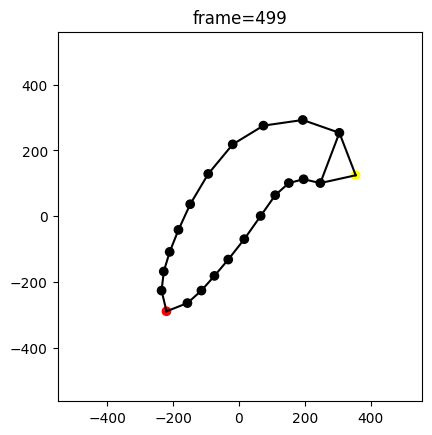

In [34]:
# plot animation: 
plot_larvee.animate_and_save(data=larvee_recon, 
                 file_name=f"autoencoder_reconstruction/autoencoder_reconstruction.gif", 
                 num_frames=500)

latent_space.shape=(2999, 8)


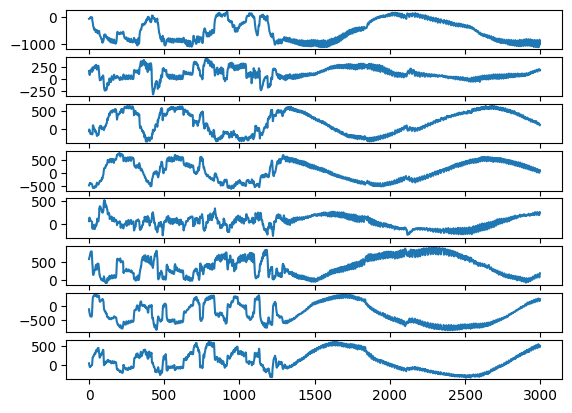

In [35]:
# Visualize latent space: 

latent_space = model.encoder(data_tensor).detach().numpy()

print(f"{latent_space.shape=}")

fig, axs = plt.subplots(nrows=8, ncols=1)
for i_ax, ax in enumerate(axs):
    ax.plot(latent_space[:, i_ax])

# 2. Maximally predictive states on autoencoder

In [36]:
import deeptime as dtime
from sklearn.cluster import MiniBatchKMeans, KMeans
import scipy

from utils_dennis.maximally_predictive_states import (time_delay_embedding, 
                                                      cluster_data, 
                                                      compare_time_series, 
                                                      get_entropy
                                                      )

#### 2.1 Timedelay-embedding + clustering

In [49]:
X = latent_space

delay = 0
n_clusters = 1000

traj_matrix = time_delay_embedding(data=X, delay=delay)
print(f"{traj_matrix.shape=}")

labels, centers, kmeans_model = cluster_data(data=traj_matrix,
                                             n_clusters=n_clusters,
                                             random_state=1,
                                             algorithm="minibatchkmeans")
print(f"{labels.shape=}")
print(f"{centers.shape=}")

print(f"Delay = {delay} = {delay/5} seconds.")

traj_matrix.shape=(2999, 8)
labels.shape=(2999,)
centers.shape=(1000, 8)
Delay = 0 = 0.0 seconds.


traj_matrix_reconstructed.shape=(2999, 8)


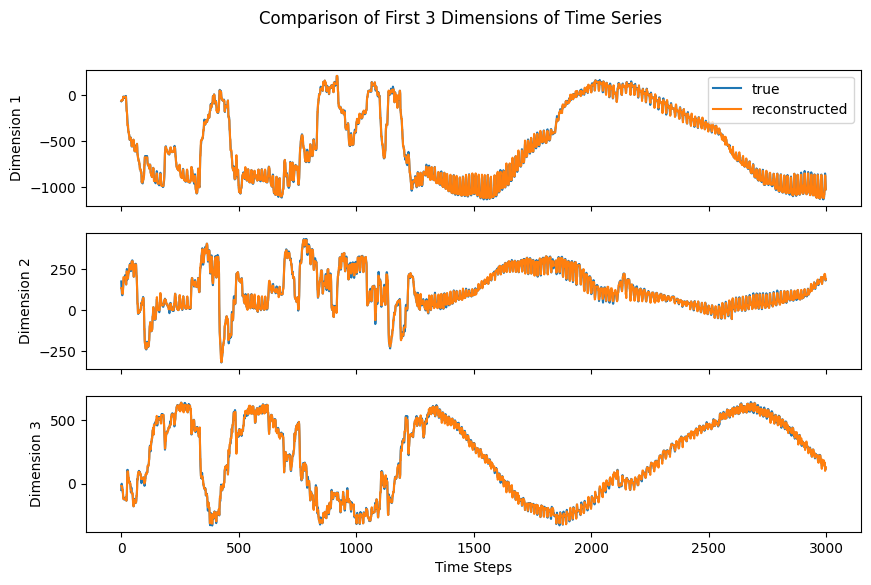

In [50]:
# reconstruct timeseries: 
traj_matrix_reconstructed = centers[labels, :]
print(f"{traj_matrix_reconstructed.shape=}")

# plot reconstruction: 
compare_time_series(traj_matrix[:, :], traj_matrix_reconstructed[:, :], k=3,
                    label1="true", label2="reconstructed")

#### 2.2 Create transition matrix with deeptime: 

In [51]:
lag = 1

# count matrix: 
C = dtime.markov.tools.estimation.count_matrix(labels,
                                               lag=lag,
                                               sliding=True)

P = dtime.markov.tools.estimation.transition_matrix(C, reversible=False)

cmap = plt.get_cmap('seismic')  # You can choose any other colormap
cmap.set_under('white')
plt.imshow(P.toarray(), cmap=cmap, interpolation='nearest', aspect='auto', vmin=0.0001,
           vmax=1)
plt.colorbar()
plt.title("Transition matrix")
plt.xlabel("states")
plt.ylabel("states")

ValueError: matrix C contains rows with sum zero.

#### 2.3 Sample Markov model

In [40]:
msm = dtime.markov.msm.MarkovStateModel(P)

start_time = 400

start_state_real_space = traj_matrix[[start_time], :]
print(f"{start_state_real_space.shape=}")
start_state_discrete = kmeans_model.predict(start_state_real_space)
print(f"{start_state_discrete.shape=}")

n_steps = 1000
simulated_labels = msm.simulate(n_steps=n_steps, start=start_state_discrete, dt=1,
                                seed=1)
print(f"{simulated_labels.shape=}")

simulated_latent_space_delay = centers[simulated_labels]
print(f"{simulated_latent_space_delay.shape=}")

start_state_real_space.shape=(1, 40)
start_state_discrete.shape=(1,)
simulated_labels.shape=(1000,)
simulated_latent_space_delay.shape=(1000, 40)


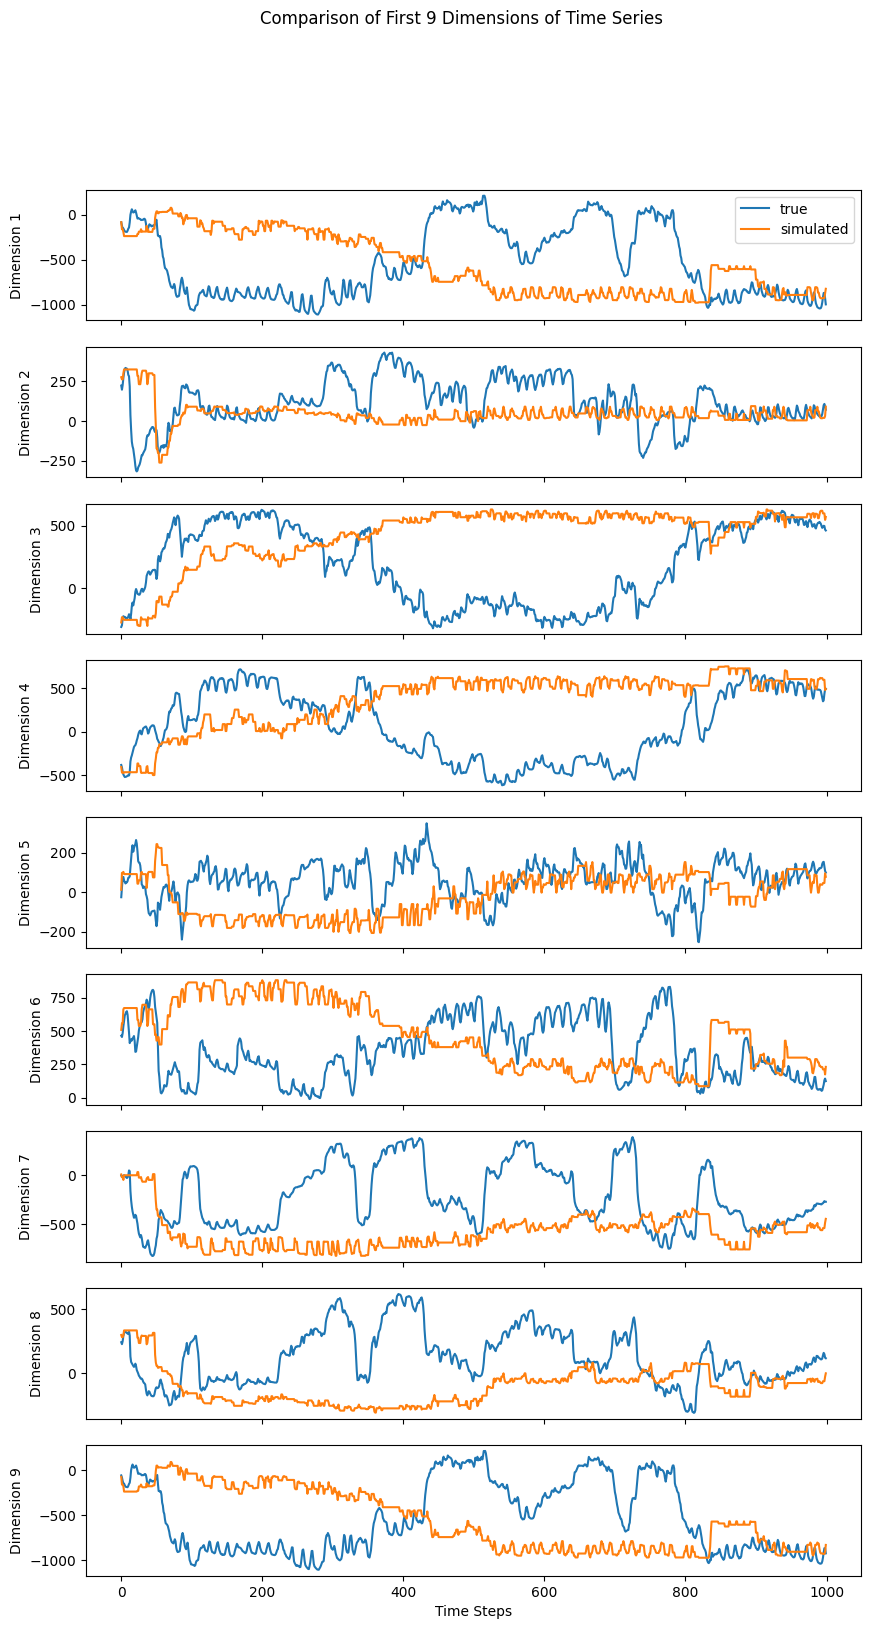

In [45]:
# plot reconstruction: 
time_window = 1000

compare_time_series(traj_matrix[start_time:start_time + time_window, :],
                    simulated_latent_space_delay[:time_window, :], k=9, label1="true",
                    label2="simulated")

In [42]:
simulated_latent_space_nodelay = simulated_latent_space_delay[:, :8]
print(f"{simulated_latent_space_nodelay.shape=}")

# simualted real space: 
latent_tensor = torch.tensor(simulated_latent_space_nodelay, dtype=torch.float32)
reconstructed_markov = model.decoder(latent_tensor).detach().numpy().reshape((latent_tensor.shape[0], 22, 2))
print(f"{reconstructed_markov.shape=}")

simulated_latent_space_nodelay.shape=(1000, 8)
reconstructed_markov.shape=(1000, 22, 2)


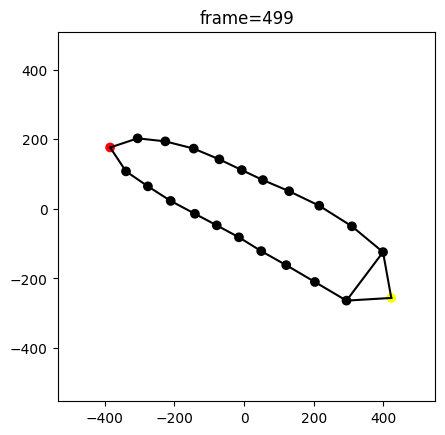

In [43]:
# Markov simulation: 

#calculate fps: 
# fps = int(10/lag)

plot_larvee.animate_and_save(data=reconstructed_markov, 
                 file_name=f"autoencoder_reconstruction/markov_larvee_ae_v3.gif", num_frames=500)

#### 2.4. Entropy sweep

In [46]:
# Calculate entropy for various delays and number of clusters. 
lag_use = 1

delay_list = np.arange(2, 30, 4, dtype=int)
n_clusters_list = np.array(np.logspace(2, 3, 4), dtype=int)
# n_clusters_list = np.array([100, 200, 500, 1000, 1500], dtype=int)
entropy_data = np.zeros((len(delay_list), len(n_clusters_list)))
for i_delay, delay in enumerate(delay_list):
    traj_matrix_use = time_delay_embedding(data=X, delay=delay)
    for i_n_clusters, n_clusters in enumerate(n_clusters_list):
        labels_use, _, _ = cluster_data(data=traj_matrix_use, n_clusters=n_clusters,
                                        random_state=1, algorithm="minibatchkmeans")
        C_use = dtime.markov.tools.estimation.count_matrix(labels_use,
                                                           lag=lag_use,
                                                           sliding=True)
        C_use = dtime.markov.tools.estimation.largest_connected_submatrix(C_use, directed=True)
        print(f"{C_use.shape=}")
        connected_bool = dtime.markov.tools.analysis.is_connected(C_use, directed=True)
        print(f"{connected_bool=}")
        P_use = dtime.markov.tools.estimation.transition_matrix(C_use, reversible=False)
        entropy = get_entropy(P_use)
        entropy_data[i_delay, i_n_clusters] = entropy
        print(f"Computed for {delay} delays and {n_clusters} clusters. entropy={entropy:.3f}\n")

C_use.shape=(99, 99)
connected_bool=True
Computed for 2 delays and 100 clusters. entropy=0.594
C_use.shape=(213, 213)
connected_bool=True
Computed for 2 delays and 215 clusters. entropy=0.690
C_use.shape=(454, 454)
connected_bool=True
Computed for 2 delays and 464 clusters. entropy=0.721
C_use.shape=(992, 992)
connected_bool=True
Computed for 2 delays and 1000 clusters. entropy=0.585
C_use.shape=(99, 99)
connected_bool=True
Computed for 6 delays and 100 clusters. entropy=0.500
C_use.shape=(213, 213)
connected_bool=True
Computed for 6 delays and 215 clusters. entropy=0.684
C_use.shape=(462, 462)
connected_bool=True
Computed for 6 delays and 464 clusters. entropy=0.773
C_use.shape=(991, 991)
connected_bool=True
Computed for 6 delays and 1000 clusters. entropy=0.685
C_use.shape=(100, 100)
connected_bool=True
Computed for 10 delays and 100 clusters. entropy=0.457
C_use.shape=(214, 214)
connected_bool=True
Computed for 10 delays and 215 clusters. entropy=0.656
C_use.shape=(462, 462)
connect

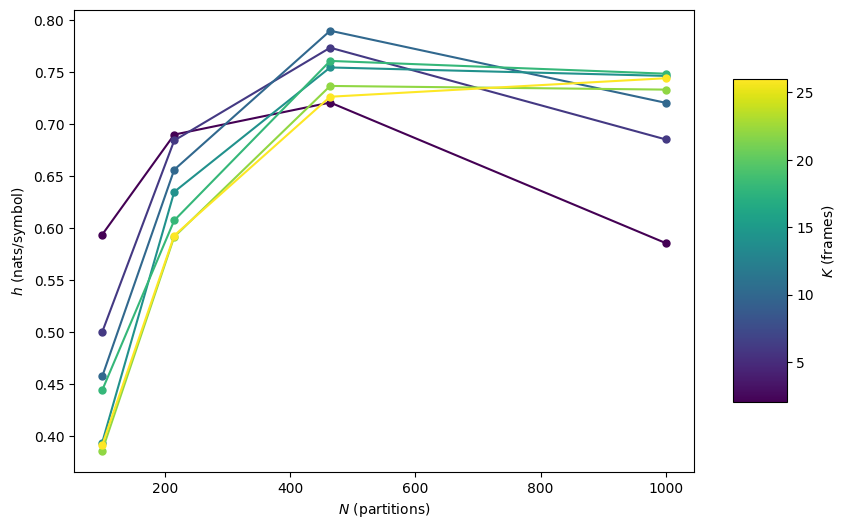

delay_list=array([ 2,  6, 10, 14, 18, 22, 26])
n_clusters_list=array([ 100,  215,  464, 1000])
max_h_K=array([0.72056132, 0.77328131, 0.78960571, 0.75428706, 0.76057153,
       0.7365139 , 0.7439405 ])


In [47]:
# lot entropy vs n_clusters and delays. 
colors_K = plt.cm.viridis(np.linspace(0, 1, len(delay_list)))
max_h_K = np.zeros(len(delay_list))
cil_h_K = np.zeros(len(delay_list))
ciu_h_K = np.zeros(len(delay_list))
max_idx_array = np.zeros(len(delay_list), dtype=int)
plt.figure(figsize=(10, 6))

for k in range(len(delay_list)):
    plt.errorbar(n_clusters_list, entropy_data[k], c=colors_K[int(k)], capsize=4,
                 marker='o', ms=5)
    max_idx = np.argmax(entropy_data[k])
    max_idx_array[k] = int(max_idx)
    max_h_K[k] = entropy_data[k][max_idx]

plt.scatter(n_clusters_list, entropy_data[k], c=entropy_data[k], vmin=min(delay_list),
            vmax=max(delay_list), s=0)
plt.colorbar(shrink=.7, aspect=6, label='$K$ (frames)')
plt.xlabel('$N$ (partitions)')
plt.ylabel('$h$ (nats/symbol)')
#plt.xscale('log')
plt.show()

print(f"{delay_list=}")
print(f"{n_clusters_list=}")
print(f"{max_h_K=}")

n_cluster = 464


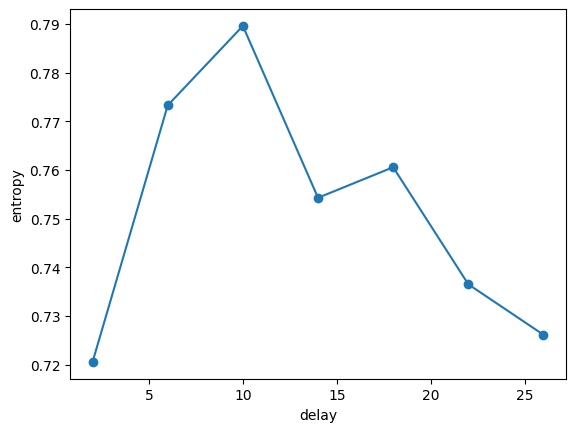

In [48]:
n_cluster_index = 2
plt.plot(delay_list, entropy_data[:, n_cluster_index], marker='o')
plt.xlabel("delay")
plt.ylabel("entropy")
print(f"n_cluster = {n_clusters_list[n_cluster_index]}")